First I will load in the dataset

In [1]:
import pandas as pd

file = "steel.csv"
df = pd.read_csv(file)

df.head(), df.shape

(   normalising_temperature  tempering_temperature  percent_silicon  \
 0                  178.500                    275           0.1530   
 1                  178.500                    950           0.1530   
 2                  178.500                    375           0.1530   
 3                  178.500                    900           0.1530   
 4                  189.525                    900           0.1624   
 
    percent_chromium  percent_copper  percent_nickel  percent_sulphur  \
 0          0.970575           0.942          0.8870              0.0   
 1          1.212726           0.942          0.8870              0.0   
 2          1.621165           0.942          0.8870              0.0   
 3          0.809989           0.942          0.8870              0.0   
 4          1.036229           0.849          0.9382              0.0   
 
    percent_carbon  percent_manganese  tensile_strength  
 0           1.920                0.0         25.107613  
 1           1.9

In [2]:
# select independent and dependent variables
dependent_col = "tensile_strength"
independent_cols = [col for col in df.columns if col != dependent_col]

X = df[independent_cols]
y = df[dependent_col]

X.head(), y.head(), X.shape, y.shape

(   normalising_temperature  tempering_temperature  percent_silicon  \
 0                  178.500                    275           0.1530   
 1                  178.500                    950           0.1530   
 2                  178.500                    375           0.1530   
 3                  178.500                    900           0.1530   
 4                  189.525                    900           0.1624   
 
    percent_chromium  percent_copper  percent_nickel  percent_sulphur  \
 0          0.970575           0.942          0.8870              0.0   
 1          1.212726           0.942          0.8870              0.0   
 2          1.621165           0.942          0.8870              0.0   
 3          0.809989           0.942          0.8870              0.0   
 4          1.036229           0.849          0.9382              0.0   
 
    percent_carbon  percent_manganese  
 0           1.920                0.0  
 1           1.920                0.0  
 2          

In [3]:
# set up evaluation metrics

from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [12]:
# implementing 10 fold cross validation
from sklearn.model_selection import KFold

def evaluate_model(model, X, Y):
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    train_rmse_list = []
    test_rmse_list = []
    train_r2_list = []
    test_r2_list = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]

        model.fit(X_train, y_train)

        # Training set predictions
        y_train_pred = model.predict(X_train)
        train_rmse_list.append(rmse(y_train, y_train_pred))
        train_r2_list.append(r2_score(y_train, y_train_pred))
        
        # Test set predictions
        y_test_pred = model.predict(X_test)
        test_rmse_list.append(rmse(y_test, y_test_pred))
        test_r2_list.append(r2_score(y_test, y_test_pred))
    
    avg_train_rmse = np.mean(train_rmse_list)
    avg_train_r2 = np.mean(train_r2_list)
    avg_test_rmse = np.mean(test_rmse_list)
    avg_test_r2 = np.mean(test_r2_list)

    return avg_train_rmse, avg_train_r2, avg_test_rmse, avg_test_r2

Now I will setup the Random Forest model with the default hyperparameters

In [13]:
from sklearn.ensemble import RandomForestRegressor

rf_default = RandomForestRegressor(random_state=42) # default n_estimators=100, max_depth=None, max_features=1, criterion=squared_error

rf_train_rmse_default, rf_train_r2_default, rf_test_rmse_default, rf_test_r2_default = evaluate_model(rf_default, X, y)

print(f"RF Default - Train RMSE: {rf_train_rmse_default:.4f}, Train R²: {rf_train_r2_default:.4f}")
print(f"RF Default - Test RMSE: {rf_test_rmse_default:.4f}, Test R²: {rf_test_r2_default:.4f}")

RF Default - Train RMSE: 10.9339, Train R²: 0.9856
RF Default - Test RMSE: 28.2760, Test R²: 0.8959


Now I will test for different values of n estimators to see results

In [36]:
n_values = [50, 100, 200, 300]

train_rmse_n = []
test_rmse_n = []
train_r2_n = []
test_r2_n = []

for n in n_values:
    model = RandomForestRegressor(n_estimators=n, random_state=42)
    train_rmse, train_r2, test_rmse, test_r2 = evaluate_model(model, X, y)
    train_rmse_n.append(train_rmse)
    train_r2_n.append(train_r2)
    test_rmse_n.append(test_rmse)
    test_r2_n.append(test_r2)
    print(f"RF with n_estimators={n}")
    print(f"  Train - RMSE: {train_rmse:.4f}, R²: {train_r2:.4f}")
    print(f"  Test  - RMSE: {test_rmse:.4f}, R²: {test_r2:.4f}")

RF with n_estimators=50
  Train - RMSE: 11.1876, R²: 0.9849
  Test  - RMSE: 28.6173, R²: 0.8936
RF with n_estimators=100
  Train - RMSE: 10.9339, R²: 0.9856
  Test  - RMSE: 28.2760, R²: 0.8959
RF with n_estimators=200
  Train - RMSE: 10.6875, R²: 0.9862
  Test  - RMSE: 28.1092, R²: 0.8970
RF with n_estimators=300
  Train - RMSE: 10.6675, R²: 0.9862
  Test  - RMSE: 28.0709, R²: 0.8970


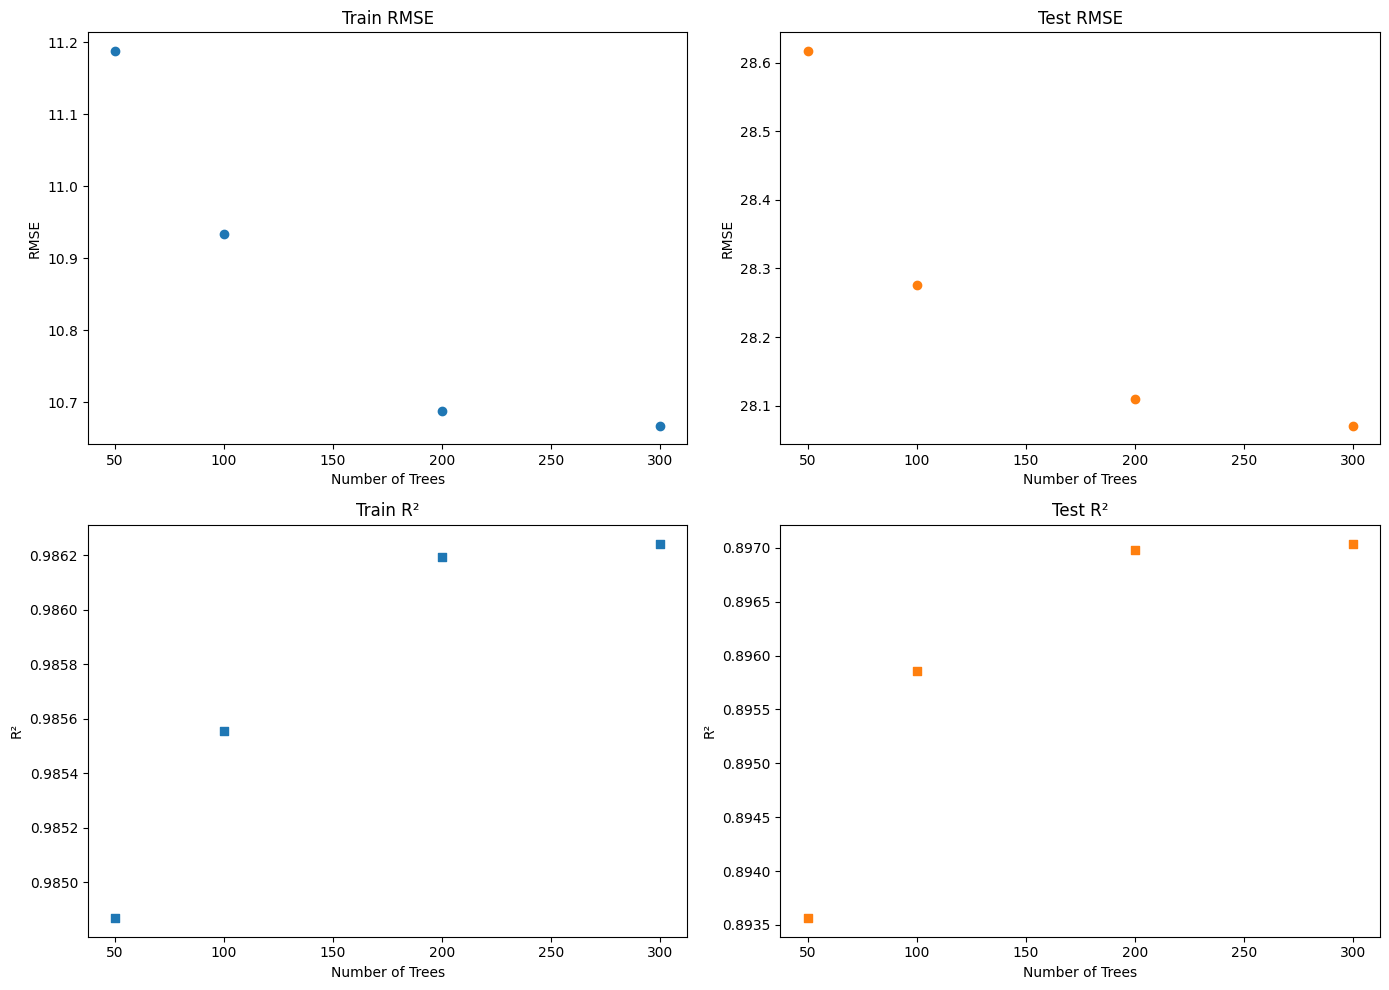

In [37]:
# plot results
import matplotlib.pyplot as plt

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))

# Train RMSE
ax1.scatter(n_values, train_rmse_n, marker='o', color='tab:blue')
ax1.set_xlabel('Number of Trees')
ax1.set_ylabel('RMSE')
ax1.set_title('Train RMSE')

# Test RMSE
ax2.scatter(n_values, test_rmse_n, marker='o', color='tab:orange')
ax2.set_xlabel('Number of Trees')
ax2.set_ylabel('RMSE')
ax2.set_title('Test RMSE')

# Train R²
ax3.scatter(n_values, train_r2_n, marker='s', color='tab:blue')
ax3.set_xlabel('Number of Trees')
ax3.set_ylabel('R²')
ax3.set_title('Train R²')

# Test R²
ax4.scatter(n_values, test_r2_n, marker='s', color='tab:orange')
ax4.set_xlabel('Number of Trees')
ax4.set_ylabel('R²')
ax4.set_title('Test R²')

plt.tight_layout()
plt.show()

I will explore different values of max depth and see results

In [38]:
depth_values = [None, 10, 20, 30]

train_rmse_depth = []
train_r2_depth = []
test_rmse_depth = []
test_r2_depth = []

for d in depth_values:
    model = RandomForestRegressor(max_depth=d, random_state=42)
    train_rmse, train_r2, test_rmse, test_r2 = evaluate_model(model, X, y)
    train_rmse_depth.append(train_rmse)
    train_r2_depth.append(train_r2)
    test_rmse_depth.append(test_rmse)
    test_r2_depth.append(test_r2)
    print(f"Random Forest with max_depth={d}")
    print(f"  Train - RMSE: {train_rmse:.4f}, R²: {train_r2:.4f}")
    print(f"  Test  - RMSE: {test_rmse:.4f}, R²: {test_r2:.4f}")

Random Forest with max_depth=None
  Train - RMSE: 10.9339, R²: 0.9856
  Test  - RMSE: 28.2760, R²: 0.8959
Random Forest with max_depth=10
  Train - RMSE: 12.5667, R²: 0.9809
  Test  - RMSE: 28.6603, R²: 0.8930
Random Forest with max_depth=20
  Train - RMSE: 10.9350, R²: 0.9856
  Test  - RMSE: 28.2800, R²: 0.8959
Random Forest with max_depth=30
  Train - RMSE: 10.9339, R²: 0.9856
  Test  - RMSE: 28.2760, R²: 0.8959


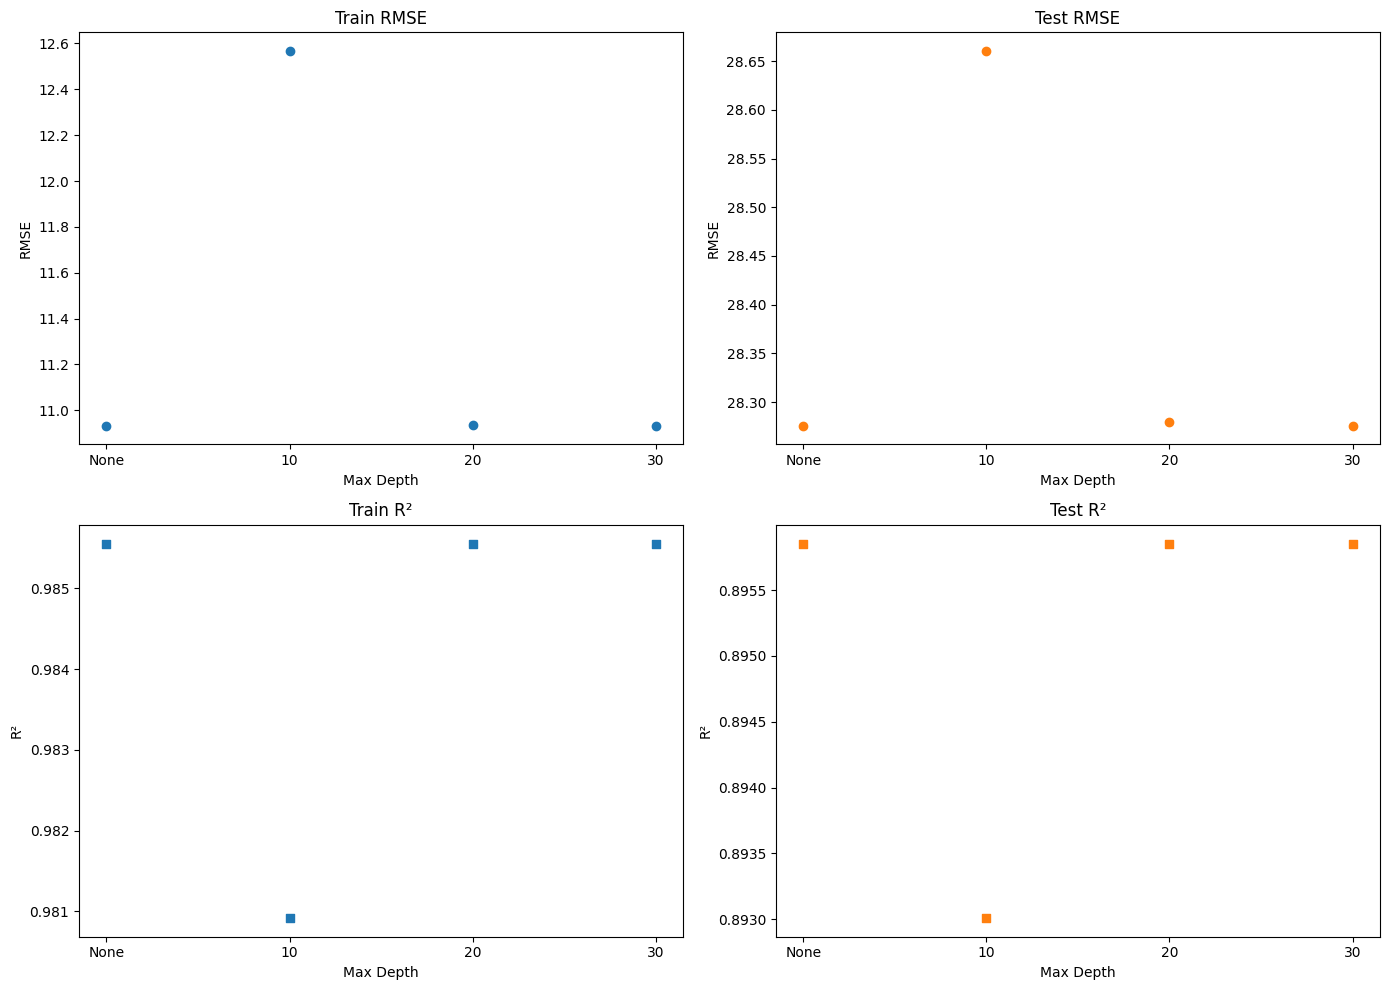

In [39]:
#plot results
depth_labels = [str(d) if d is not None else "None" for d in depth_values]
x_positions = range(len(depth_values))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))

# Train RMSE
ax1.scatter(x_positions, train_rmse_depth, marker='o', color='tab:blue')
ax1.set_xlabel('Max Depth')
ax1.set_ylabel('RMSE')
ax1.set_title('Train RMSE')
ax1.set_xticks(x_positions)
ax1.set_xticklabels(depth_labels)

# Test RMSE
ax2.scatter(x_positions, test_rmse_depth, marker='o', color='tab:orange')
ax2.set_xlabel('Max Depth')
ax2.set_ylabel('RMSE')
ax2.set_title('Test RMSE')
ax2.set_xticks(x_positions)
ax2.set_xticklabels(depth_labels)

# Train R²
ax3.scatter(x_positions, train_r2_depth, marker='s', color='tab:blue')
ax3.set_xlabel('Max Depth')
ax3.set_ylabel('R²')
ax3.set_title('Train R²')
ax3.set_xticks(x_positions)
ax3.set_xticklabels(depth_labels)

# Test R²
ax4.scatter(x_positions, test_r2_depth, marker='s', color='tab:orange')
ax4.set_xlabel('Max Depth')
ax4.set_ylabel('R²')
ax4.set_title('Test R²')
ax4.set_xticks(x_positions)
ax4.set_xticklabels(depth_labels)

plt.tight_layout()
plt.show()

Now I will explore tuning both hyperparameters

In [45]:
from sklearn.model_selection import GridSearchCV, cross_val_score

param_grid = {
    "n_estimators": [50, 100, 200, 300],
    "max_depth": [None, 10, 20, 30]
}

# Use same KFold strategy as evaluate_model for consistency
kf_consistent = KFold(n_splits=10, shuffle=True, random_state=42)

grid_rf = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, scoring="neg_mean_squared_error", cv=kf_consistent)

grid_rf.fit(X, y)

best_params = grid_rf.best_params_
best_rmse = np.sqrt(-grid_rf.best_score_)

# Get R² for best model using cross_val_score with same cv
best_model = grid_rf.best_estimator_
best_r2_scores = cross_val_score(best_model, X, y, cv=kf_consistent, scoring='r2')
best_r2 = best_r2_scores.mean()

print(f"Best Parameters: {best_params}")
print(f"Best Test RMSE: {best_rmse:.4f}")
print(f"Best Test R²: {best_r2:.4f}")

Best Parameters: {'max_depth': None, 'n_estimators': 300}
Best Test RMSE: 28.3559
Best Test R²: 0.8970


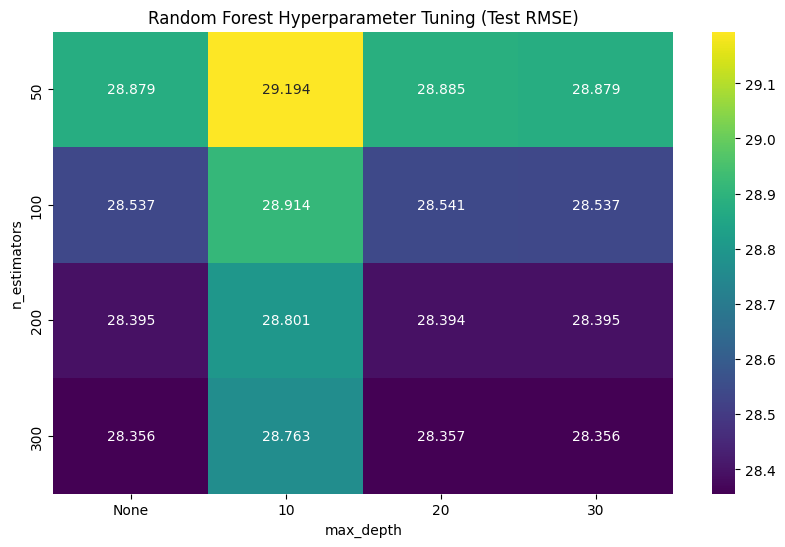

In [55]:
# Fixed heatmap using cv_results_ directly with correct param ordering
import seaborn as sns
import pandas as pd

# Build DataFrame from GridSearchCV results
cv_df = pd.DataFrame(grid_rf.cv_results_)
cv_df['rmse'] = np.sqrt(-cv_df['mean_test_score'])

# Convert None to string 'None' in the param column before pivoting
cv_df['param_max_depth'] = cv_df['param_max_depth'].apply(lambda x: 'None' if x is None else x)

# rows=n_estimators, cols=max_depth, values=RMSE
pivot_rmse = cv_df.pivot(index='param_n_estimators', columns='param_max_depth', values='rmse')

# Reindex with string 'None' instead of None
max_depth_for_reindex = ['None' if d is None else d for d in param_grid['max_depth']]
pivot_rmse = pivot_rmse.reindex(index=param_grid['n_estimators'], columns=max_depth_for_reindex)

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_rmse, annot=True, fmt=".3f", xticklabels=pivot_rmse.columns, yticklabels=pivot_rmse.index, cmap="viridis")
plt.xlabel('max_depth')
plt.ylabel('n_estimators')
plt.title('Random Forest Hyperparameter Tuning (Test RMSE)')
plt.show()

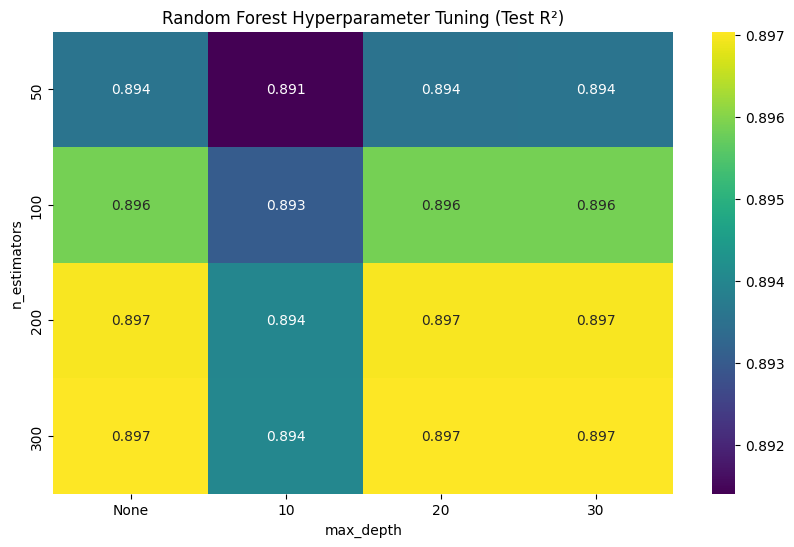

In [54]:
# R^2 heatmap

r2_matrix = np.zeros((len(param_grid['n_estimators']), len(param_grid['max_depth'])))

for i, n_estimators in enumerate(param_grid['n_estimators']):
    for j, max_depth in enumerate(param_grid['max_depth']):
        model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
        # Use same cv strategy as GridSearchCV
        r2_scores = cross_val_score(model, X, y, cv=kf_consistent, scoring='r2')
        r2_matrix[i, j] = r2_scores.mean()

# Create labels for max_depth that show "None" instead of None
depth_labels = [str(d) if d is not None else "None" for d in param_grid['max_depth']]

plt.figure(figsize=(10, 6))
sns.heatmap(r2_matrix, annot=True, fmt='.3f', xticklabels=depth_labels, yticklabels=param_grid['n_estimators'], cmap='viridis')
plt.xlabel('max_depth')
plt.ylabel('n_estimators')
plt.title('Random Forest Hyperparameter Tuning (Test R²)')
plt.show()